In [ ]:
import numpy as np
import pandas as pd
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import torch
import torch.optim as optim
import torch.nn as nn
import higher
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import copy

In [ ]:
data_dir = 'E:/Py_Files/cold/archive'

data_files = [f'combined_data_{i}.txt' for i in range(1, 5)]


In [ ]:
data_files = [data_files[0]]  
print(f'Files to be processed: {data_files}')

Files to be processed: ['combined_data_1.txt']


 Initialize Sets to Store Unique IDs

In [4]:
unique_user_ids = set()
unique_movie_ids = set()

We'll read the data files line by line and collect user and movie IDs without storing the entire dataset.

In [5]:
for file in data_files:
    print(f'Collecting unique IDs from {file}...')
    with open(os.path.join(data_dir, file), 'r') as f:
        movie_id = None
        for line in f:
            line = line.strip()
            if line.endswith(':'):
                # Movie ID line
                movie_id = int(line.replace(':', ''))
                unique_movie_ids.add(movie_id)
            else:
                # User data line
                user_id_str, rating_str, date = line.split(',')
                user_id = int(user_id_str)
                unique_user_ids.add(user_id)


In [6]:
unique_user_ids = list(unique_user_ids)
unique_movie_ids = list(unique_movie_ids)
print(f'Total unique users: {len(unique_user_ids)}')
print(f'Total unique movies: {len(unique_movie_ids)}')

Total unique users: 470758
Total unique movies: 4499


In [7]:
train_ratio = 0.35  # 35% for training
test_ratio = 0.05   # 5% for testing

In [ ]:
# Set random seed
random.seed(42)

# Shuffle and sample users
random.shuffle(unique_user_ids)
num_train_users = int(train_ratio * len(unique_user_ids))
num_test_users = int(test_ratio * len(unique_user_ids))

train_users = set(unique_user_ids[:num_train_users])
test_users = set(unique_user_ids[num_train_users:num_train_users + num_test_users])

print(f'Number of training users: {len(train_users)}')
print(f'Number of testing users: {len(test_users)}')

Number of training users: 164765
Number of testing users: 23537


In [9]:
selected_users = train_users.union(test_users)
user_id_map = {user_id: idx for idx, user_id in enumerate(selected_users)}
num_users = len(user_id_map)
print(f'Number of selected users: {num_users}')

Number of selected users: 188302


In [10]:
movie_id_map = {movie_id: idx for idx, movie_id in enumerate(unique_movie_ids)}
num_movies = len(movie_id_map)
print(f'Number of movies: {num_movies}')

Number of movies: 4499


In [11]:
train_user_ids = []
train_movie_ids = []
train_preferences = []

test_user_ids = []
test_movie_ids = []
test_preferences = []

In [ ]:
for file in data_files:
    print(f'Processing {file} for data collection...')
    with open(os.path.join(data_dir, file), 'r') as f:
        movie_id = None
        for line in tqdm(f):
            line = line.strip()
            if line.endswith(':'):
                # Movie ID line
                movie_id_raw = int(line.replace(':', ''))
                movie_id_enc = movie_id_map.get(movie_id_raw)
                if movie_id_enc is None:
                    continue  # Skip movies not in the mapping 
            else:
                # User data line
                user_id_str, rating_str, date = line.split(',')
                user_id_raw = int(user_id_str)
                if user_id_raw in user_id_map:
                    user_id_enc = user_id_map[user_id_raw]
                    rating = int(rating_str)
                    preference = 1 if rating > 3 else 0
                    if user_id_raw in train_users:
                        train_user_ids.append(user_id_enc)
                        train_movie_ids.append(movie_id_enc)
                        train_preferences.append(preference)
                    elif user_id_raw in test_users:
                        test_user_ids.append(user_id_enc)
                        test_movie_ids.append(movie_id_enc)
                        test_preferences.append(preference)

Processing combined_data_1.txt for data collection...


24058263it [00:41, 576707.06it/s]


In [13]:
# Training data
train_data = pd.DataFrame({
    'UserID_enc': train_user_ids,
    'MovieID_enc': train_movie_ids,
    'Preference': train_preferences
})

# Testing data
test_data = pd.DataFrame({
    'UserID_enc': test_user_ids,
    'MovieID_enc': test_movie_ids,
    'Preference': test_preferences
})

print('Data collection completed.')
print(f'Training data shape: {train_data.shape}')
print(f'Testing data shape: {test_data.shape}')

Data collection completed.
Training data shape: (8424744, 3)
Testing data shape: (1202982, 3)


Create Tasks for Meta-Learning

In [14]:
# Group the training data by user
user_groups = train_data.groupby('UserID_enc')
print(f'Number of training users with data: {len(user_groups)}')

Number of training users with data: 164765


Define Support and Query Set Sizes

In [ ]:
K_support = 5   # Number of samples in the support set / user
K_query = 15    # Number of samples in the query set / user

In [16]:
tasks = []

for user_id, group in user_groups:
    if len(group) >= (K_support + K_query):
        # Shuffle the user's data
        user_data = group.sample(frac=1, random_state=42).reset_index(drop=True)
        # Split into support and query sets
        support_set = user_data.iloc[:K_support]
        query_set = user_data.iloc[K_support:K_support + K_query]
        tasks.append({'user_id': user_id, 'support_set': support_set, 'query_set': query_set})
    else:
        # Skip users with insufficient data
        continue

print(f'Number of tasks created: {len(tasks)}')


Number of tasks created: 90995


Define the MetaCS-DNN Model

In [17]:
class MetaCSDNN(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=64, hidden_sizes=[64, 32]):
        super(MetaCSDNN, self).__init__()
        # Embedding layers
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.item_embedding = nn.Embedding(num_items, embedding_size)
        
        # Fully connected layers
        fc_input_size = embedding_size * 2
        self.fc_layers = nn.ModuleList()
        for hidden_size in hidden_sizes:
            self.fc_layers.append(nn.Linear(fc_input_size, hidden_size))
            fc_input_size = hidden_size  # Update input size for next layer
        
        # Output layer
        self.output_layer = nn.Linear(fc_input_size, 1)
        
    def forward(self, user_ids, item_ids):
        # Embeddings
        user_embeds = self.user_embedding(user_ids)
        item_embeds = self.item_embedding(item_ids)
        x = torch.cat([user_embeds, item_embeds], dim=1)
        
        # Hidden layers with ReLU activation
        for fc_layer in self.fc_layers:
            x = fc_layer(x)
            x = F.relu(x)
        
        # Output layer with sigmoid activation
        x = self.output_layer(x)
        out = torch.sigmoid(x)
        return out.squeeze()


In [ ]:
# Define model parameters
embedding_size = 64
hidden_sizes = [64, 32]

# Instantiate the model
num_users_model = num_users  # Number of selected users
num_items_model = num_movies  # Number of movies in the data

model = MetaCSDNN(num_users=num_users_model, num_items=num_items_model, embedding_size=embedding_size, hidden_sizes=hidden_sizes)

# Move the model to device 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(model)

MetaCSDNN(
  (user_embedding): Embedding(188302, 64)
  (item_embedding): Embedding(4499, 64)
  (fc_layers): ModuleList(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
  )
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)


Define Dataset Class

In [19]:
class UserTaskDataset(Dataset):
    def __init__(self, data):
        self.user_ids = data['UserID_enc'].values
        self.item_ids = data['MovieID_enc'].values
        self.labels = data['Preference'].values.astype(np.float32)
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        user_id = self.user_ids[idx]
        item_id = self.item_ids[idx]
        label = self.labels[idx]
        return torch.tensor(user_id, dtype=torch.long), torch.tensor(item_id, dtype=torch.long), torch.tensor(label)

In [20]:
first_task = tasks[0]
first_task

{'user_id': 0,
 'support_set':    UserID_enc  MovieID_enc  Preference
 0           0         1137           1
 1           0         2616           1
 2           0           29           1
 3           0         3859           1
 4           0         1904           1,
 'query_set':     UserID_enc  MovieID_enc  Preference
 5            0         1306           1
 6            0         2451           1
 7            0          190           1
 8            0         3637           1
 9            0          807           1
 10           0          272           1
 11           0         1961           1
 12           0         2548           1
 13           0          456           1
 14           0          482           1
 15           0         3578           1
 16           0         2991           1
 17           0         3623           0
 18           0         3045           1
 19           0         4431           1}

In [21]:
# Support set DataLoader
support_dataset = UserTaskDataset(first_task['support_set'])
support_loader = DataLoader(support_dataset, batch_size=K_support, shuffle=True)

# Query set DataLoader
query_dataset = UserTaskDataset(first_task['query_set'])
query_loader = DataLoader(query_dataset, batch_size=K_query, shuffle=True)

In [22]:
# Define hyperparameters
meta_lr = 0.0001       # Learning rate for meta-optimizer (outer loop)
inner_lr = 0.001      # Learning rate for task-specific learner (inner loop)
num_inner_steps = 15  # Number of inner-loop updates per task
num_epochs = 4       # Number of epochs for meta-training
start_epoch = 0

# Define loss function
loss_fn = nn.BCELoss()

# Initialize the meta-optimizer
meta_optimizer = optim.Adam(model.parameters(), lr=meta_lr)

inner_optimizer = torch.optim.SGD(model.parameters(), lr=inner_lr)

In [ ]:
# Lists to store losses
all_epoch_losses = []
all_support_losses = []
all_query_losses = []

In [24]:
# Checkpoint directory
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [25]:
# Check for existing checkpoint
checkpoint_path = os.path.join(checkpoint_dir, 'meta_model_checkpoint.pth')
if os.path.exists(checkpoint_path):
    print('Loading checkpoint...')
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    meta_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Resume from the next epoch
    all_epoch_losses = checkpoint['all_epoch_losses']
    all_support_losses = checkpoint['all_support_losses']
    all_query_losses = checkpoint['all_query_losses']
    print(f'Resuming training from epoch {start_epoch+1}')
else:
    print('No checkpoint found. Starting training from scratch.')

Loading checkpoint...


C:\Users\SAM\AppData\Local\Temp\ipykernel_20976\1377023360.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


Resuming training from epoch 5


In [ ]:
# Begin meta-training
for epoch in range(start_epoch, num_epochs):
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    epoch_loss = 0.0
    epoch_support_loss = 0.0
    epoch_query_loss = 0.0

    # Optionally, shuffle tasks at the beginning of each epoch
    random.shuffle(tasks)

    # Create a tqdm progress bar for tasks
    task_progress = tqdm(enumerate(tasks), total=len(tasks), desc='Tasks', leave=False)

    for task_idx, task in task_progress:
        # Get the support and query sets for the current task
        support_set = task['support_set']
        query_set = task['query_set']

        # Create data loaders for support and query sets
        support_dataset = UserTaskDataset(support_set)
        support_loader = DataLoader(support_dataset, batch_size=K_support, shuffle=True)

        query_dataset = UserTaskDataset(query_set)
        query_loader = DataLoader(query_dataset, batch_size=K_query, shuffle=True)

        # Get the data from the support set
        user_ids_supp, item_ids_supp, labels_supp = next(iter(support_loader))
        user_ids_supp = user_ids_supp.to(device)
        item_ids_supp = item_ids_supp.to(device)
        labels_supp = labels_supp.to(device)

        # Get the data from the query set
        user_ids_query, item_ids_query, labels_query = next(iter(query_loader))
        user_ids_query = user_ids_query.to(device)
        item_ids_query = item_ids_query.to(device)
        labels_query = labels_query.to(device)

        # Zero the gradients of the meta-optimizer
        meta_optimizer.zero_grad()

        # higher to create a functional model for inner-loop updates
        with higher.innerloop_ctx(model, inner_optimizer, copy_initial_weights=False) as (fmodel, diffopt):
            # Inner-loop adaptation
            for inner_step in range(num_inner_steps):
                # Forward pass on support set
                preds_supp = fmodel(user_ids_supp, item_ids_supp)
                loss_supp = loss_fn(preds_supp, labels_supp)
                # Compute gradients and update model parameters
                diffopt.step(loss_supp)

            # Accumulate support loss
            epoch_support_loss += loss_supp.item()

            # Compute loss on query set with updated parameters
            preds_query = fmodel(user_ids_query, item_ids_query)
            loss_query = loss_fn(preds_query, labels_query)
            # Accumulate query loss
            epoch_query_loss += loss_query.item()

            # Backpropagate the meta-loss
            loss_query.backward()

        # Update the meta-parameters
        meta_optimizer.step()

        # Update the progress bar with task-level losses
        task_progress.set_postfix({
            'Task': f'{task_idx+1}/{len(tasks)}',
            'Support Loss': f'{loss_supp.item():.4f}',
            'Query Loss': f'{loss_query.item():.4f}'
        })

    # Average losses over all tasks
    avg_support_loss = epoch_support_loss / len(tasks)
    avg_query_loss = epoch_query_loss / len(tasks)
    avg_epoch_loss = avg_query_loss  # The meta-loss is based on the query loss

    # Store losses for analysis
    all_support_losses.append(avg_support_loss)
    all_query_losses.append(avg_query_loss)
    all_epoch_losses.append(avg_epoch_loss)

    # Print epoch-level losses
    print(f'Epoch {epoch+1}/{num_epochs} - Average Support Loss: {avg_support_loss:.4f}, Average Query Loss (Meta Loss): {avg_query_loss:.4f}')

    # Save checkpoint after each epoch
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': meta_optimizer.state_dict(),
        'all_epoch_losses': all_epoch_losses,
        'all_support_losses': all_support_losses,
        'all_query_losses': all_query_losses
    }
    torch.save(checkpoint, checkpoint_path)
    print(f'Checkpoint saved at epoch {epoch+1}')

Preparing Test Tasks

First, we need to create tasks for the test users, similar to how we did for the training users.

In [27]:
# Group the test data by user
test_user_groups = test_data.groupby('UserID_enc')
print(f'Number of test users: {len(test_user_groups)}')

Number of test users: 23537


Since we have only positive samples, we'll adjust our K_support and K_query accordingly.

In [ ]:
K_support = 5    # Number of samples in the support set / user
K_query_pos = 15 # Number of positive samples in the query set / user

Create Test Tasks

Since we need negative samples for evaluation, we'll generate them by sampling items that the user has not interacted with.

We need to prepare a set of negative samples for each user by sampling items they haven't rated.

Initialize Lists to Store Metrics

In [ ]:
# Lists to store metrics
precision_at_k = {1: [], 3: [], 5: []}
auroc_list = []
mrr_list = []

In [30]:
all_item_ids = set(train_data['MovieID_enc'].unique()).union(set(test_data['MovieID_enc'].unique()))

In [36]:
def generate_negative_samples(user_id, num_negatives, all_item_ids, user_interacted_items):
    non_interacted_items = list(all_item_ids - user_interacted_items)  # Convert to list here
    # Randomly sample negative items
    negative_items = random.sample(non_interacted_items, num_negatives)
    return negative_items


Prepare Test Tasks with Negative Samples

In [32]:
K_support = 5    # Number of samples in the support set per user
K_query_pos = 15 # Number of positive samples in the query set per user
K_query_neg = 15 # Number of negative samples in the query set per user

In [34]:
test_tasks = []

# All unique item IDs
all_item_ids = set(train_data['MovieID_enc'].unique()).union(set(test_data['MovieID_enc'].unique()))

In [ ]:
# Iterate over each user in the test data
for user_id, group in test_user_groups:
    # Positive samples
    pos_samples = group
    user_interacted_items = set(pos_samples['MovieID_enc'].unique())
    
    # Check if the user has enough positive samples and negative samples
    if len(pos_samples) >= (K_support + K_query_pos) and len(user_interacted_items) < len(all_item_ids):
        # Shuffle positive samples
        pos_samples = pos_samples.sample(frac=1, random_state=42).reset_index(drop=True)
        
        # Create support set
        support_set = pos_samples.iloc[:K_support]
        
        # Create positive query set
        query_set_pos = pos_samples.iloc[K_support:K_support + K_query_pos]
        
        # Generate negative samples
        negative_item_ids = generate_negative_samples(
            user_id=user_id,  # Pass the encoded user ID directly
            num_negatives=K_query_neg, 
            all_item_ids=all_item_ids, 
            user_interacted_items=user_interacted_items
        )
        # Create negative query set
        query_set_neg = pd.DataFrame({
            'UserID_enc': [user_id] * len(negative_item_ids),
            'MovieID_enc': negative_item_ids,
            'Preference': [0] * len(negative_item_ids)
        })
        
        # Combine positive and negative query sets
        query_set = pd.concat([query_set_pos, query_set_neg]).sample(frac=1, random_state=42).reset_index(drop=True)
        
        test_tasks.append({'user_id': user_id, 'support_set': support_set, 'query_set': query_set})
    else:
        # Skip users with insufficient data or no negative samples
        continue

print(f'Number of test tasks created: {len(test_tasks)}')

Number of test tasks created: 13141


In [38]:
# Lists to store metrics
precision_at_k = {1: [], 3: [], 5: []}
auroc_list = []
ndcg_at_k = {1: [], 3: [], 5: []}
mrr_list = []

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize cumulative sums and counts for average metrics
cumulative_auroc = 0.0
num_valid_auroc = 0
cumulative_mrr = 0.0
cumulative_precision_at_k = {1: 0.0, 3: 0.0, 5: 0.0}
cumulative_ndcg_at_k = {1: 0.0, 3: 0.0, 5: 0.0}

# evaluation mode
model.eval()

# progress bar for test tasks
test_task_progress = tqdm(enumerate(test_tasks), total=len(test_tasks), desc='Meta-Testing', leave=False)

for task_idx, task in test_task_progress:
    # Get the support and query sets for the current task
    support_set = task['support_set']
    query_set = task['query_set']
    user_id = task['user_id']
    
    # Create data loaders for support and query sets
    support_dataset = UserTaskDataset(support_set)
    support_loader = DataLoader(support_dataset, batch_size=K_support, shuffle=False)
    
    query_dataset = UserTaskDataset(query_set)
    query_loader = DataLoader(query_dataset, batch_size=len(query_set), shuffle=False)
    
    # Get the data from the support set
    user_ids_supp, item_ids_supp, labels_supp = next(iter(support_loader))
    user_ids_supp = user_ids_supp.to(device)
    item_ids_supp = item_ids_supp.to(device)
    labels_supp = labels_supp.to(device)
    
    # Get the data from the query set
    user_ids_query, item_ids_query, labels_query = next(iter(query_loader))
    user_ids_query = user_ids_query.to(device)
    item_ids_query = item_ids_query.to(device)
    labels_query = labels_query.to(device)
    
    # Create a copy of the model for adaptation
    adapted_model = copy.deepcopy(model)
    adapted_model.to(device)
    
    # Adaptation using support set (fine-tuning)
    adaptation_steps = 1
    adaptation_lr = 1e-2
    optimizer = torch.optim.SGD(adapted_model.parameters(), lr=adaptation_lr)
    adapted_model.train()
    
    for _ in range(adaptation_steps):
        # No torch.no_grad() here, we need gradients for adaptation
        preds_supp = adapted_model(user_ids_supp, item_ids_supp)
        loss_supp = loss_fn(preds_supp, labels_supp)
        optimizer.zero_grad()
        loss_supp.backward()
        optimizer.step()
    
    # Evaluation on query set
    adapted_model.eval()
    with torch.no_grad():  # Disable gradients for evaluation
        preds_query = adapted_model(user_ids_query, item_ids_query)
    
    # Move data to CPU and convert to numpy arrays
    preds_query_np = preds_query.cpu().numpy()
    labels_query_np = labels_query.cpu().numpy()
    
    # Compute AUROC
    try:
        auroc = roc_auc_score(labels_query_np, preds_query_np)
        if not np.isnan(auroc):
            cumulative_auroc += auroc
            num_valid_auroc += 1
    except ValueError:
        # Handle case where only one class is present in y_true
        auroc = np.nan
    auroc_list.append(auroc)
    
    # Compute MRR
    # Rank the items based on predicted scores
    ranked_indices = np.argsort(-preds_query_np)
    ranked_labels = labels_query_np[ranked_indices]
    # Find the rank of each relevant item
    ranks = np.where(ranked_labels == 1)[0]
    if len(ranks) > 0:
        mrr = np.mean(1.0 / (ranks + 1))
    else:
        mrr = 0.0
    cumulative_mrr += mrr
    mrr_list.append(mrr)
    
    # Compute Precision@K and nDCG@K
    for k in [1, 3, 5]:
        top_k_indices = ranked_indices[:k]
        top_k_labels = ranked_labels[:k]
        precision = np.mean(top_k_labels)
        precision_at_k[k].append(precision)
        cumulative_precision_at_k[k] += precision

        # Compute DCG@K
        gains = top_k_labels  # rel_i in binary relevance
        discounts = np.log2(np.arange(2, k + 2))
        dcg = np.sum(gains / discounts)

        # Compute IDCG@K
        ideal_gains = np.sort(labels_query_np)[::-1][:k]
        ideal_discounts = np.log2(np.arange(2, k + 2))
        idcg = np.sum(ideal_gains / ideal_discounts)

        # Avoid division by zero
        ndcg = dcg / idcg if idcg > 0 else 0.0
        ndcg_at_k[k].append(ndcg)
        cumulative_ndcg_at_k[k] += ndcg

    # Compute average metrics so far
    avg_auroc = cumulative_auroc / num_valid_auroc if num_valid_auroc > 0 else np.nan
    avg_mrr = cumulative_mrr / (task_idx + 1)
    avg_precision_at_k = {k: cumulative_precision_at_k[k] / (task_idx + 1) for k in [1, 3, 5]}
    avg_ndcg_at_k = {k: cumulative_ndcg_at_k[k] / (task_idx + 1) for k in [1, 3, 5]}
    
    # Update the progress bar with average metrics
    test_task_progress.set_postfix({
        'Avg AUROC': f'{avg_auroc:.4f}' if not np.isnan(avg_auroc) else 'nan',
        'Avg MRR': f'{avg_mrr:.4f}',
        'Avg P@1': f'{avg_precision_at_k[1]:.4f}',
        'Avg P@3': f'{avg_precision_at_k[3]:.4f}',
        'Avg P@5': f'{avg_precision_at_k[5]:.4f}',
        'Avg nDCG@5': f'{avg_ndcg_at_k[5]:.4f}'
    })


In [42]:
# compute final average metrics
auroc_array = np.array([x for x in auroc_list if not np.isnan(x)])
mean_auroc = np.mean(auroc_array)
mean_mrr = np.mean(mrr_list)
mean_precision_at_k = {k: np.mean(precision_at_k[k]) for k in [1, 3, 5]}
mean_ndcg_at_k = {k: np.mean(ndcg_at_k[k]) for k in [1, 3, 5]}

print('\nFinal Evaluation Metrics on Test Set:')
print(f'Average AUROC: {mean_auroc:.4f}')
print(f'Average MRR: {mean_mrr:.4f}')
for k in [1, 3, 5]:
    print(f'Average Precision@{k}: {mean_precision_at_k[k]:.4f}')
for k in [1, 3, 5]:
    print(f'Average nDCG@{k}: {mean_ndcg_at_k[k]:.4f}')


Final Evaluation Metrics on Test Set:
Average AUROC: 0.7175
Average MRR: 0.2170
Average Precision@1: 0.6429
Average Precision@3: 0.5989
Average Precision@5: 0.5643
Average nDCG@1: 0.6429
Average nDCG@3: 0.6107
Average nDCG@5: 0.5902


In [43]:
# Remove NaNs from AUROC list
auroc_array = np.array([x for x in auroc_list if not np.isnan(x)])
mean_auroc = np.mean(auroc_array)

mean_mrr = np.mean(mrr_list)

mean_precision_at_k = {}
for k in [1, 3, 5]:
    mean_precision_at_k[k] = np.mean(precision_at_k[k])

In [44]:
print('\nFinal Evaluation Metrics on Test Set:')
print(f'Average AUROC: {mean_auroc:.4f}')
print(f'Average MRR: {mean_mrr:.4f}')
for k in [1, 3, 5]:
    print(f'Average Precision@{k}: {mean_precision_at_k[k]:.4f}')


Final Evaluation Metrics on Test Set:
Average AUROC: 0.7175
Average MRR: 0.2170
Average Precision@1: 0.6429
Average Precision@3: 0.5989
Average Precision@5: 0.5643


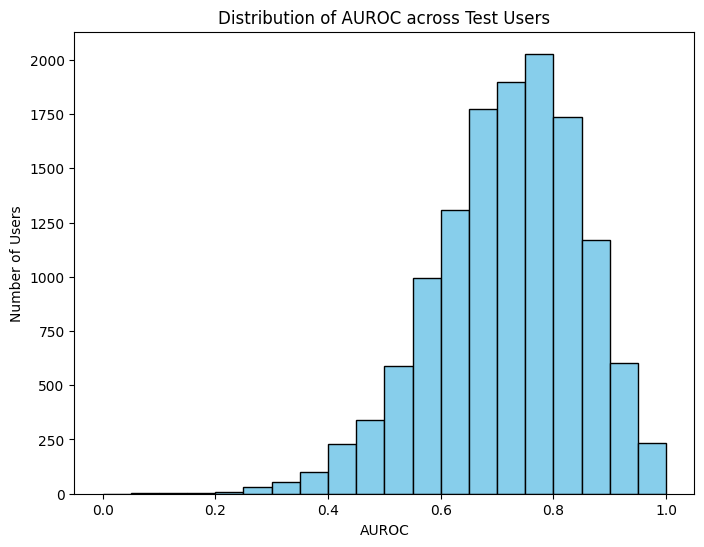

In [45]:
plt.figure(figsize=(8, 6))
plt.hist(auroc_array, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of AUROC across Test Users')
plt.xlabel('AUROC')
plt.ylabel('Number of Users')
plt.show()

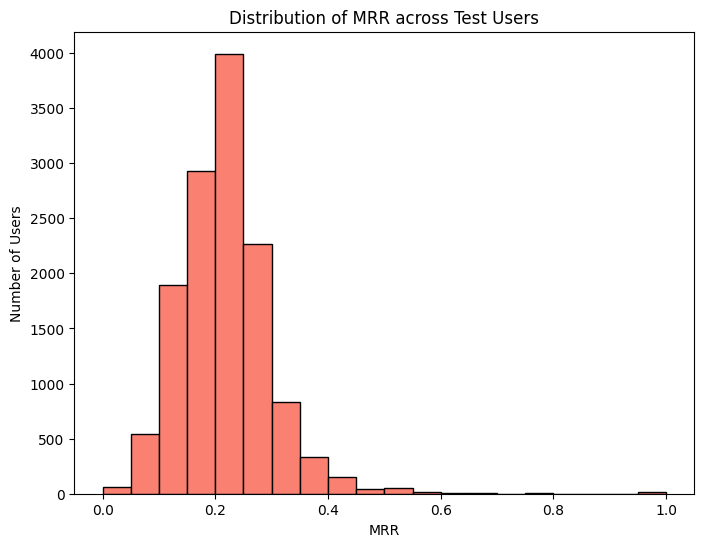

In [46]:
plt.figure(figsize=(8, 6))
plt.hist(mrr_list, bins=20, color='salmon', edgecolor='black')
plt.title('Distribution of MRR across Test Users')
plt.xlabel('MRR')
plt.ylabel('Number of Users')
plt.show()

C:\Users\SAM\AppData\Local\Temp\ipykernel_20976\929882771.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=['Precision@1', 'Precision@3', 'Precision@5'])


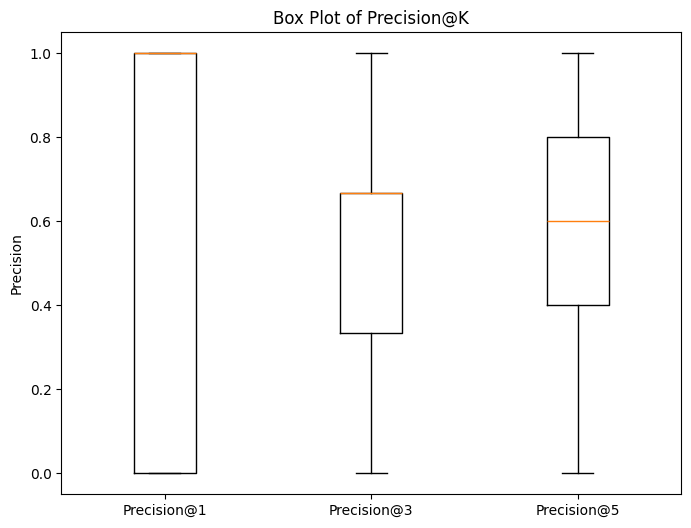

In [47]:
plt.figure(figsize=(8, 6))
data = [precision_at_k[1], precision_at_k[3], precision_at_k[5]]
plt.boxplot(data, labels=['Precision@1', 'Precision@3', 'Precision@5'])
plt.title('Box Plot of Precision@K')
plt.ylabel('Precision')
plt.show()